In [9]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *


In [10]:
np.random.seed(1)

### Simulation of a Marked Exponential Hawkes Process

We start by simulating a unidimensionnal Hawkes process denoted $N$. The intensity of the process is given by the formula : 
\begin{equation}
   \lambda(t) =   m + \int_{(-\infty ,t)\times \mathcal{E} } a e^{-b(t-s)} \phi_{\gamma, \psi}(\kappa) N(ds \times d\kappa),
\end{equation}

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [11]:
m, a, b = 0.8, -1, 2
Tmax = 5
phi_arg = 0.3

## taking kappa i.i.d following a exponential distribution of parameter 1
def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

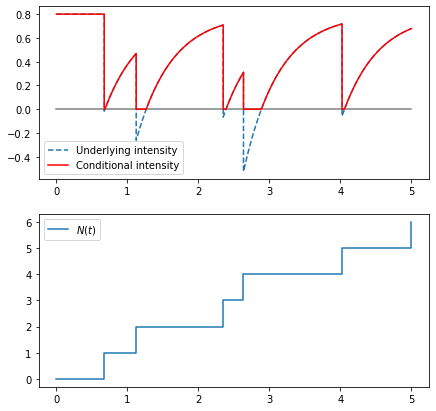

In [12]:
hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    F = F ,
                                    arg_F = {'psi':1},
                                    phi=phi, 
                                    arg_phi = {'gamma': phi_arg},
                                    max_time = Tmax)


hawkes.simulate()

fig, ax = plt.subplots(2,1, figsize=(7,7))
hawkes.plot_intensity(ax =ax)

We now consider a multidimensionnal Hawkes process for which the intensity $\lambda_i$ of the i-th subprocess takes the form : $\begin{equation}
   \lambda_{i}(t) =   m_i + \sum_{j=1}^{d} \int_{(-\infty ,t)\times \mathcal{E}} a_{ij} e^{-b_i(t-s)} \phi_{\gamma, \psi}(\kappa) N^j(ds \times d\kappa),
\end{equation}$

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [13]:
m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [-0.4, 0.3]] )
b = np.array([[1],[1.5]])


Tmax = 10
phi_arg = 0.5

def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

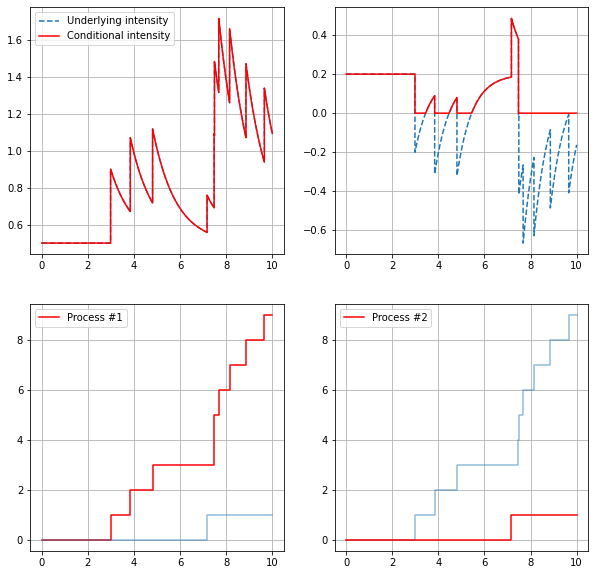

In [14]:
hawkes_multi = multivariate_exponential_hawkes_marked(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      phi = phi, 
                                                      F= F, 
                                                      arg_phi={'gamma':phi_arg}, 
                                                      arg_F={'psi': 2}, 
                                                      max_time=10)

hawkes_multi.simulate()

fig,ax = plt.subplots(2,2, figsize = (10,10))
hawkes_multi.plot_intensity(ax = ax)

# Apply testing procedure

We present here the code use to apply different test procedure on Hawkes process. To that end, we start by simulating a synthetic dataset containing 500 repetitions of a Hawkes process.

In [15]:
## simualtion of the observations

### data generation
m=1
a = 0.6
b = 2.1
Tmax = 500


NbSample = 50
SubSample = int(NbSample**(2/3) )



tList = []
mark_list = []


for k in range(100):
    hawkes_ex =   exp_thinning_hawkes(m=m, a = a, b=b, max_time=Tmax)
    hawkes_ex.simulate()    
    tList += [hawkes_ex.timestamps]
    mark_list +=[np.random.exponential(scale=1,size=len(hawkes_ex.timestamps))]

#%%
learner = estimator_unidim_multi_rep()
learner.fit(tList)

opti ended


array([1.02220241, 0.61175545, 2.33191668])

## Test on one coefficient

Hypothesis under test: $\mathcal{H}_0 : m = 1 \quad \text{ vs } \quad \mathcal{H}_1 : m \ne 1$.

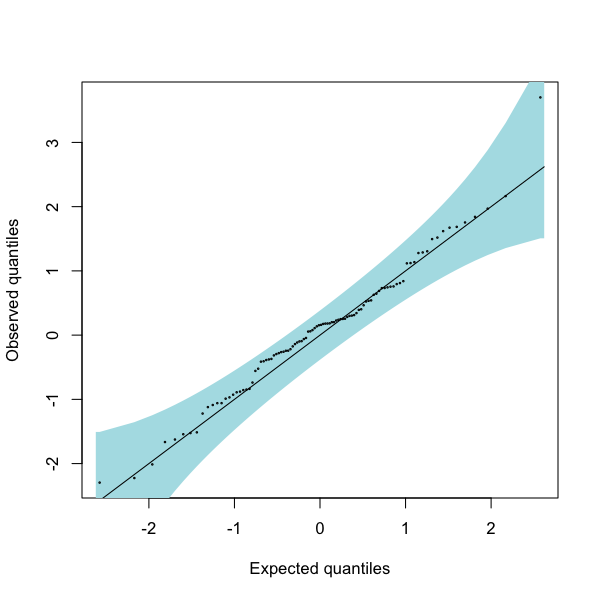

In [4]:
stat = learner.test_one_coeff(0,1)  

Hypothesis under test: $\mathcal{H}_0 : a = 1 \quad \text{ vs } \quad \mathcal{H}_1 : a \ne 1$.

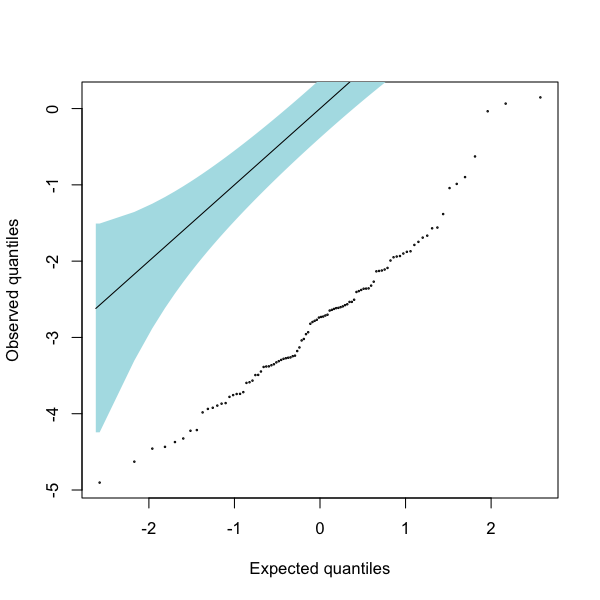

In [5]:
stat = learner.test_one_coeff(1,1)  

### Test of equality between coefficients 

Hypothesis under test: $\mathcal{H}_0 : a = m \quad \text{ vs } \quad \mathcal{H}_1 : a \ne m$.

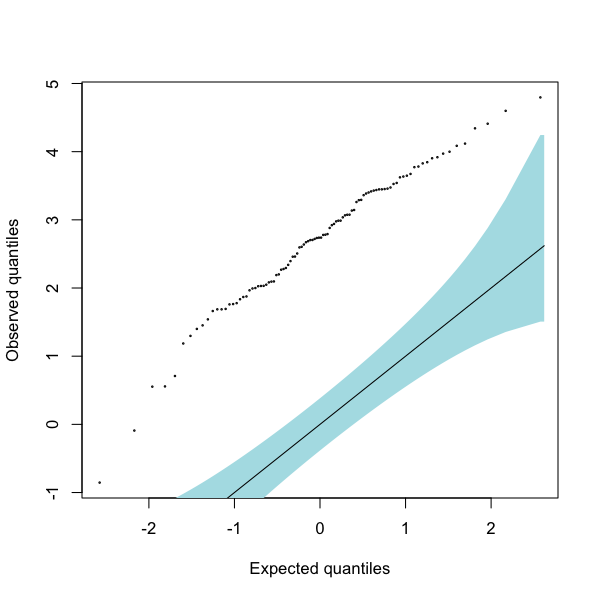

In [6]:
stat = learner.test_equality_coeff(0,1)

### Test on the model used for estimation

We present here different test on the model associated to the data, model relying on the GOF procedure. 

#### Test of the self-exiting assumption

Hypothesis under test: $\mathcal{H}_0 : \text{data are i.i.d represetation of a poisson model with an unknown parameter} $.

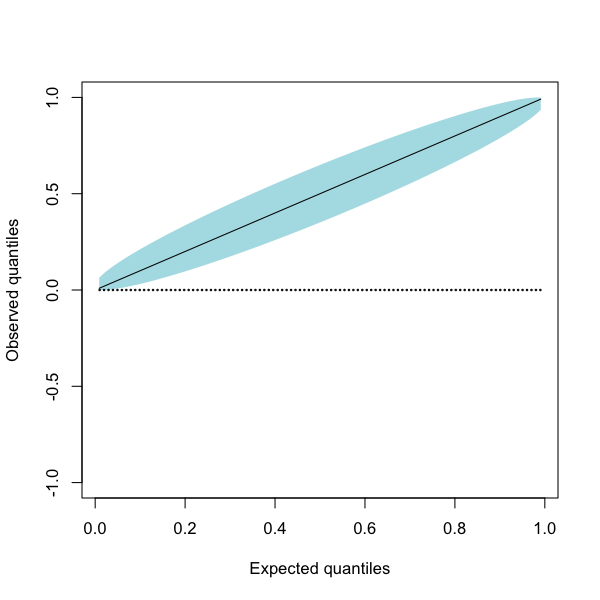

In [5]:
stats_poisson = learner.GOF_bootstrap(compensator_func=poisson_compensator,Nb_SubSample=50)

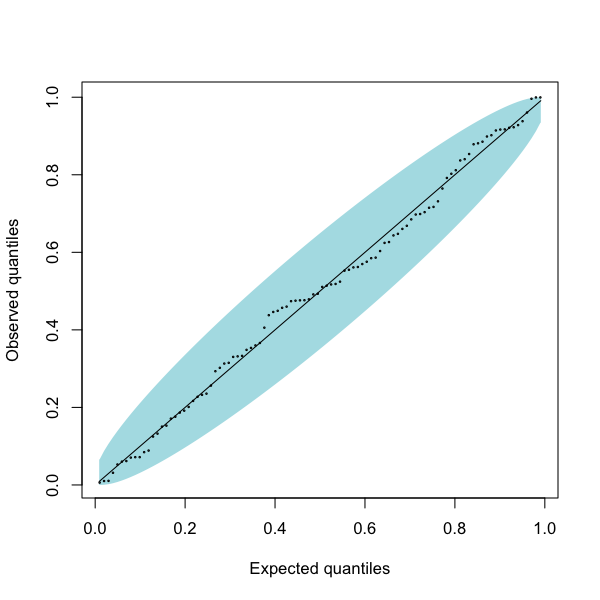

In [7]:
stats_hawkes = learner.GOF_bootstrap(Nb_SubSample=100)

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a hawkes model inhibition} $$

In [8]:
learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(tList)

array([0.78032001, 0.        , 1.        ])

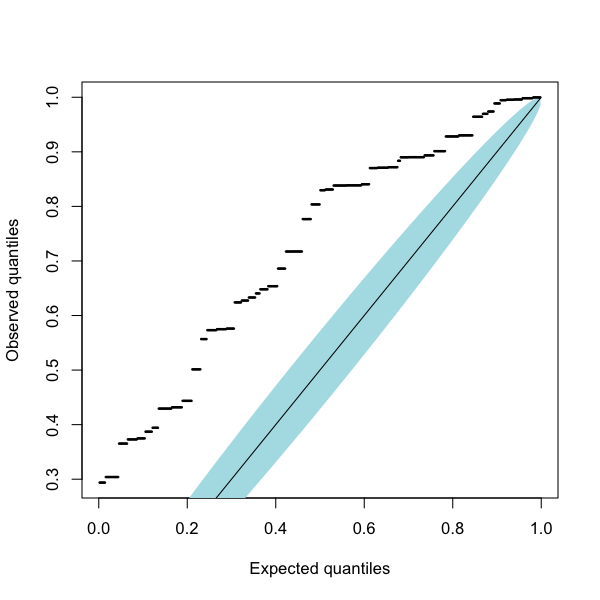

In [10]:
stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(sup_compensator=100)

### Test of the marked assumpation

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked hawkes model} $$

In [1]:

"""
tList = []
mark_list = []


for k in range(100):
    hawkes = exp_thinning_hawkes_marked(m=m,
                                        a=a, 
                                        b=b, 
                                        F=F, 
                                        arg_F={'psi':0.5}, 
                                        phi=phi, 
                                        arg_phi={'gamma':0.5}, 
                                        max_time=Tmax)
    hawkes.simulate()
    tList+=[hawkes.timestamps]
    mark_list+=[hawkes.mark_list]
    
"""

"\ntList = []\nmark_list = []\n\n\nfor k in range(100):\n    hawkes = exp_thinning_hawkes_marked(m=m,\n                                        a=a, \n                                        b=b, \n                                        F=F, \n                                        arg_F={'psi':0.5}, \n                                        phi=phi, \n                                        arg_phi={'gamma':0.5}, \n                                        max_time=Tmax)\n    hawkes.simulate()\n    tList+=[hawkes.timestamps]\n    mark_list+=[hawkes.mark_list]\n    \n"

In [15]:
import scipy.stats
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *

np.random.seed(1)


m,a,b = 1, 1.5, 2
Tmax = 1000


def F(mark,t,psi):
    return(1- np.exp( -psi*mark ))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(t,mark, psi):
    return(psi*np.exp(-psi*mark))

tlist, mlist = [], []

for k in range(100):
    hawkes = exp_thinning_hawkes_marked(m=m,
                                            a=a, 
                                            b=b, 
                                            F=F, 
                                            arg_F={'psi':2}, 
                                            phi=phi, 
                                            arg_phi={'gamma':1}, 
                                            max_time=Tmax)
    hawkes.simulate()
    tlist +=[[(time, mark) for time, mark in zip(hawkes.timestamps, hawkes.mark_list)]]

In [16]:
learner = estimator_unidim_multi_rep(mark = True, 
                                        f = f, 
                                        phi = phi, 
                                        name_arg_f=['psi'], 
                                        name_arg_phi=['gamma'], 
                                        initial_guess_phi=[0], 
                                        initial_guess_f=[1], 
                                        bound_f=[(1e-5, None)], 
                                        bound_phi=[(None, None)])

learner.fit(tlist)

array([2.48513484, 1.02156149, 0.99910727, 1.26650913, 1.99522084])

(array([5., 6., 3., 6., 7., 2., 3., 8., 5., 5.]),
 array([0.00606979, 0.10341124, 0.20075268, 0.29809413, 0.39543557,
        0.49277702, 0.59011846, 0.68745991, 0.78480136, 0.8821428 ,
        0.97948425]),
 <BarContainer object of 10 artists>)

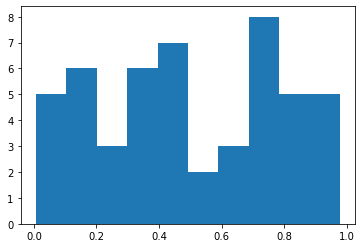

In [17]:
pvals =learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator)
plt.hist(pvals['pvalList'])

# Real dataset

In [11]:
import datetime
import pandas as pd
import matplotlib.pyplot
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('earthquake.txt')

In [13]:
def split_date(x):
    y = x.split('+')[0]
    if len(y)<=19:
        y = y +'.0'
    z = datetime.datetime(year=int(y[:4]), month = int(y[5:7]), day=int(y[8:10]), hour = int(y[11:13]), minute=int(y[14:16]), second= int(y[17:19]), microsecond=int(y[20:]))  
    baseline =datetime.datetime(year = int(y[:4]), month=1, day=1, hour=0, minute=0, second=0)

    return((z-baseline).total_seconds()/60)


In [14]:
df['date1']= df['date'].apply(split_date)
df['year']= df['date'].apply(lambda x : int(x[:4]))

In [15]:
tlist_marked = []
tlist = []

for year in np.unique(df['year']):
    
    diff_year = datetime.datetime(year = year+1, month=1, day=1, hour=0, minute=0, second=0)- datetime.datetime(year = year, month=1, day=1, hour=0, minute=0, second=0)
    tlist_marked +=  [[(0,0)] + list(df.loc[df.year == year, ['date1', 'magnitudo']].itertuples(index = False, name=None)) + [(diff_year.total_seconds()/60,0)] ]
    tlist += [[time for time,mark in tlist_marked[-1]]]

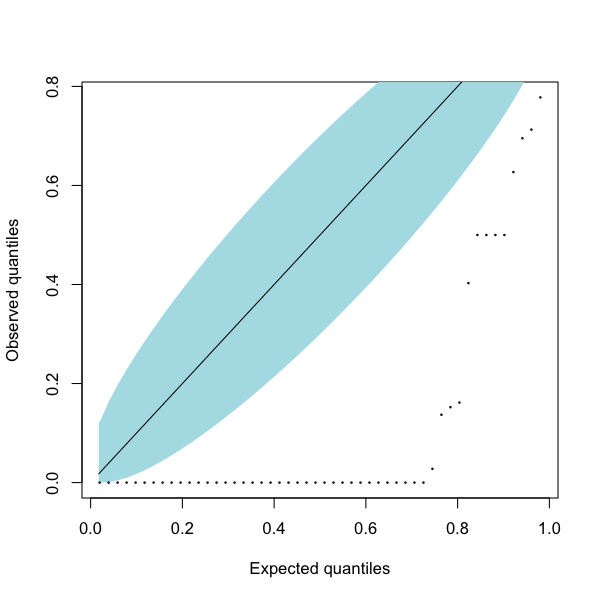

In [16]:


learner_marked_hawkes = estimator_unidim_multi_rep(mark = True, 
                                                     f = f, 
                                                     phi = phi, 
                                                     name_arg_f=['psi'], 
                                                     name_arg_phi=['gamma'], 
                                                     initial_guess_phi=[0], 
                                                     initial_guess_f=[1],
                                                     bound_f=[(1e-5,None)], 
                                                     bound_phi=[(None, None)])
learner_marked_hawkes.fit(tlist_marked)
pvals= learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_MEHP_compensator, nb_cores = 1)


In [25]:
84+91+116

291

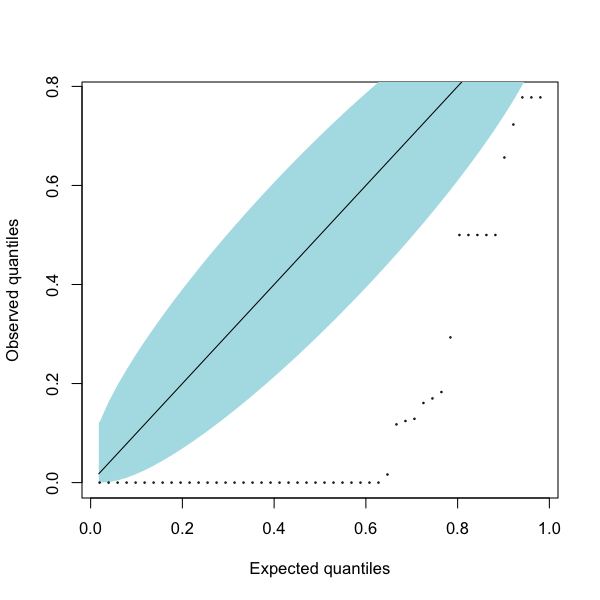

In [17]:
learner_marked_hawkes = estimator_unidim_multi_rep()
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_EHP_compensator)

1.0
1.0
1.0
1.00000001
1.00000001
1.00000001
1.01.0

1.0
1.0
1.0
1.0
1e-051e-05
1e-05

1.001e-05
1.001e-05
1e-05
1.001e-051e-05

1e-05
1e-05
1e-05
1e-05
0.9306279678215235
0.84534448874267610.9237980107856292

0.9306279778215235
0.9306279678215235
0.9306279678215235
0.9237980207856292
0.9237980107856292
0.46531898391076176
0.8453444987426761
0.9237980107856292
0.8453444887426761
0.8453444887426761
0.4619040053928145
0.422677244371338
0.46531899391076176
0.46531898391076176
0.46531898391076176
0.1397936377326
0.422677254371338
0.422677244371338
0.422677244371338
0.4619040153928145
0.46190400539281450.1113683621811824

0.4619040053928145
0.1397936477326
0.1373382509670259
0.11136837218118240.1397936377326

0.1113683621811824
0.1397936377326
0.1113683621811824
0.029379543358894256
0.04203770293036169
0.1373382609670259
0.029379553358894257
0.1373382509670259
0.029379543358894256
0.13733825096702590.029379543358894256

0.040874659028637406
1e-05
0.04087466902863741
0.040874659028637406
1.0

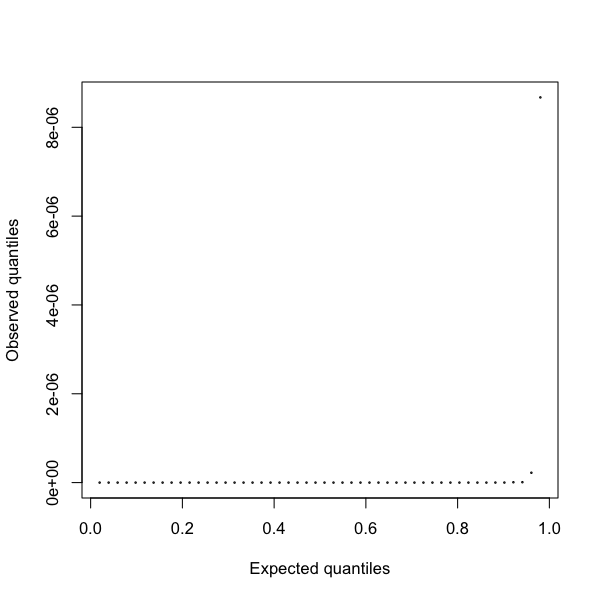

In [26]:
learner_marked_hawkes = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=poisson_compensator)